# Traffic Prediction

## Data Description :
The dataset is stored in a CSV file and includes additional columns such as time in hours, date, days of the week, and counts for each vehicle type (CarCount, BikeCount, BusCount, TruckCount). 

The "Total" column represents the total count of all vehicle types detected within a 15-minute duration. 

The dataset is updated every 15 minutes, providing a comprehensive view of traffic patterns over the course of one month. 
The dataset includes a column indicating the traffic situation categorized into four classes: 
<ol>
        <li>Heavy</li>
        <li>High</li>
        <li>Normal </li>
        <li>Low</li>
        
        
</ol>

This information can help assess the severity of congestion and monitor traffic conditions at different times and days of the week.


## Importing Nesscary Libraries

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def convert24(time):
    # Parse the time string into a datetime object
    t = datetime.strptime(time, '%I:%M:%S %p')
    # Format the datetime object into a 24-hour time string
    return t.strftime('%H:%M:%S')

def Daytime(x):
    Hour = int(x[:2])
    if Hour>=5 and Hour <12: # Morning 
        return 1
    elif Hour >=12 and Hour <17: # AfterNoon
        return 2
    elif Hour>=17 and Hour<20: # Evening
        return 3
    else:                    # Night
        return 4

def DaytimeT(x):
    Hour = int(x[:2])
    if Hour>=5 and Hour <12: # Morning 
        return "Morning"
    elif Hour >=12 and Hour <17: # AfterNoon
        return "AfterNoon"
    elif Hour>=17 and Hour<20: # Evening
        return "Evening"
    else:                    # Night
        return "Night"

def BinningMonth(DayNumber):

    if DayNumber <= 7:
        return "Q1"
    elif DayNumber > 7 and DayNumber <= 14:
        return "Q2"
    elif DayNumber > 14 and DayNumber <= 21:
        return "Q3"
    elif DayNumber > 21 and DayNumber <= 31:
        return "Q4"


df = pd.read_csv(r"Traffic dataset.csv")

In [173]:
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal
...,...,...,...,...,...,...,...,...,...
2971,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
2972,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
2973,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
2974,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


In [174]:
df.sort_values(by=["Date","Time"],inplace=True)
df.reset_index(drop=True,inplace=True)
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,10:00:00 AM,1,Wednesday,97,2,16,7,122,normal
1,10:00:00 PM,1,Wednesday,17,4,0,36,57,normal
2,10:15:00 AM,1,Wednesday,22,8,31,8,69,normal
3,10:15:00 PM,1,Wednesday,16,1,1,29,47,normal
4,10:30:00 AM,1,Wednesday,31,23,19,12,85,normal
...,...,...,...,...,...,...,...,...,...
2971,9:15:00 PM,31,Tuesday,64,14,10,6,94,low
2972,9:30:00 AM,31,Tuesday,62,2,7,22,93,normal
2973,9:30:00 PM,31,Tuesday,71,14,17,10,112,normal
2974,9:45:00 AM,31,Tuesday,92,8,11,21,132,high


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


## Data Preprocessing

### Validating Total count in every Day

In [176]:
Validate = df.CarCount+df.BusCount+df.BikeCount+df.TruckCount

In [177]:
Validate = df.CarCount+df.BusCount+df.BikeCount+df.TruckCount

In [178]:
df[~Validate==df.Total]

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation


### Weekdays Encoding

In [179]:
week_day_dict = {
    'Sunday':1,
    'Monday':2,
    'Tuesday' : 3,
    'Wednesday' : 4,
    'Thursday' : 5,
    'Friday' : 6,
    'Saturday' :7
}

In [180]:
df['Day'] = df['Day of the week'].map(week_day_dict)
# df.drop("Day of the week",axis=1,inplace=True)

### Dealing with Time 

In [181]:
df["ModifiedTime"]=df.Time.apply(convert24)

In [182]:
df.ModifiedTime

0       10:00:00
1       22:00:00
2       10:15:00
3       22:15:00
4       10:30:00
          ...   
2971    21:15:00
2972    09:30:00
2973    21:30:00
2974    09:45:00
2975    21:45:00
Name: ModifiedTime, Length: 2976, dtype: object

In [183]:
df.ModifiedTime.unique()

array(['10:00:00', '22:00:00', '10:15:00', '22:15:00', '10:30:00',
       '22:30:00', '10:45:00', '22:45:00', '11:00:00', '23:00:00',
       '11:15:00', '23:15:00', '11:30:00', '23:30:00', '11:45:00',
       '23:45:00', '00:00:00', '12:00:00', '00:15:00', '12:15:00',
       '00:30:00', '12:30:00', '00:45:00', '12:45:00', '01:00:00',
       '13:00:00', '01:15:00', '13:15:00', '01:30:00', '13:30:00',
       '01:45:00', '13:45:00', '02:00:00', '14:00:00', '02:15:00',
       '14:15:00', '02:30:00', '14:30:00', '02:45:00', '14:45:00',
       '03:00:00', '15:00:00', '03:15:00', '15:15:00', '03:30:00',
       '15:30:00', '03:45:00', '15:45:00', '04:00:00', '16:00:00',
       '04:15:00', '16:15:00', '04:30:00', '16:30:00', '04:45:00',
       '16:45:00', '05:00:00', '17:00:00', '05:15:00', '17:15:00',
       '05:30:00', '17:30:00', '05:45:00', '17:45:00', '06:00:00',
       '18:00:00', '06:15:00', '18:15:00', '06:30:00', '18:30:00',
       '06:45:00', '18:45:00', '07:00:00', '19:00:00', '07:15:

In [184]:
df["DaytimeT"] = df.ModifiedTime.apply(DaytimeT)
df["Daytime"] = df.ModifiedTime.apply(Daytime)
df["MonthQuarter"] = df.Date.apply(BinningMonth)

In [185]:
df.sort_values(by=["Date","Daytime"],inplace=True)
df.reset_index(drop=True,inplace=True)
# df.drop("Time",axis=1,inplace=True)
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Day,ModifiedTime,DaytimeT,Daytime,MonthQuarter
0,10:00:00 AM,1,Wednesday,97,2,16,7,122,normal,4,10:00:00,Morning,1,Q1
1,10:15:00 AM,1,Wednesday,22,8,31,8,69,normal,4,10:15:00,Morning,1,Q1
2,10:30:00 AM,1,Wednesday,31,23,19,12,85,normal,4,10:30:00,Morning,1,Q1
3,10:45:00 AM,1,Wednesday,49,22,16,5,92,normal,4,10:45:00,Morning,1,Q1
4,11:00:00 AM,1,Wednesday,32,5,3,21,61,normal,4,11:00:00,Morning,1,Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,8:45:00 PM,31,Tuesday,108,20,14,15,157,normal,3,20:45:00,Night,4,Q4
2972,9:00:00 PM,31,Tuesday,69,13,13,8,103,low,3,21:00:00,Night,4,Q4
2973,9:15:00 PM,31,Tuesday,64,14,10,6,94,low,3,21:15:00,Night,4,Q4
2974,9:30:00 PM,31,Tuesday,71,14,17,10,112,normal,3,21:30:00,Night,4,Q4


## Exploratory Data Analysis

<Axes: xlabel='DaytimeT', ylabel='count'>

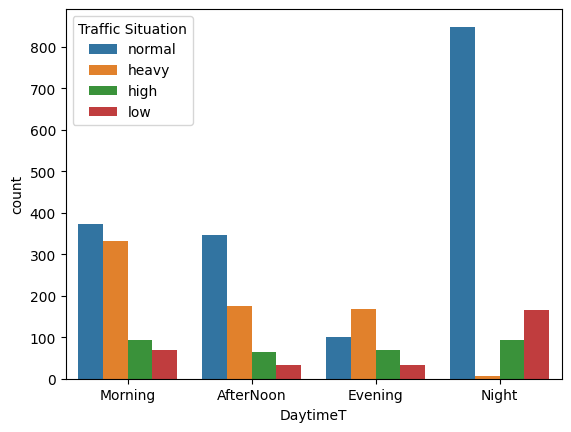

In [197]:
sns.countplot(x="DaytimeT",data=df,hue="Traffic Situation")

<Axes: xlabel='Day of the week', ylabel='count'>

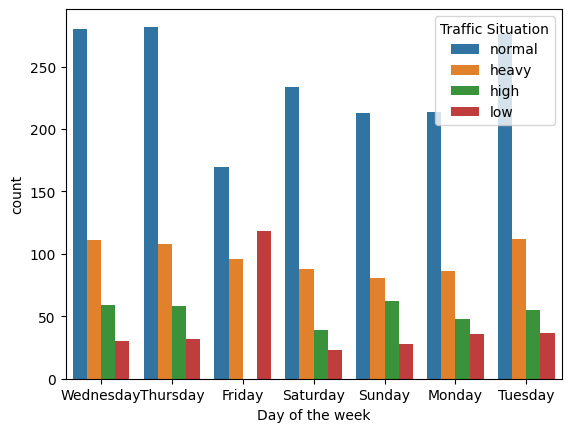

In [196]:
sns.countplot(x="Day of the week",data=df,hue="Traffic Situation")

<Axes: xlabel='MonthQuarter', ylabel='count'>

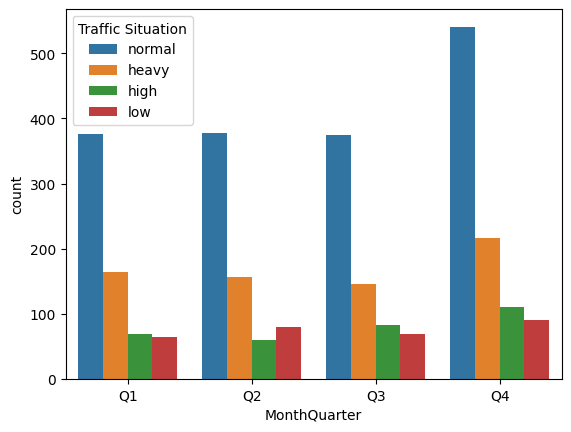

In [198]:
sns.countplot(x = "MonthQuarter" , data=df , hue="Traffic Situation" )

## Modeiling

### Droping Unnesscary 

In [188]:
# df.drop("Day of the week",axis=1,inplace=True)
# df.drop("Time",axis=1,inplace=True)